# **Predicting Concrete Compressive Strength**

### Motivation:
Concrete is a fundamental material in civil engineering. Its compressive strength is important for ensuring the safety and durability of structures. However, determining this strength accurately is challenging because it depends on a nonlinear function between several factors, including the age of the concrete and the proportions of its components—such as cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, and fine aggregate.
This project aims to apply machine learning techniques to improve the prediction of concrete strength, in order to contribute to better design, quality control, and resource optimization in construction.

### Dataset Explanation:
The dataset is sourced from the UCI Machine Learning Repository and contains 1030 observations with 8 quantitative input variables, and 1 quantitative output variable.
The input variables are: cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, fine aggregate and age. Except for age, the other variables are ingredient quantities in the concrete mixture and measured in *kg in a $m^{3}$* mixture. The age is measured in *days*.
The target, concrete compressive strengt, is measured in *MPa*.

### Data Analytics: Preprocessing
Since there is no missing attribute values according to the information provided by UCI Machine Learning Repository. Data can be directly read from Concrete_data.csv. 

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn

from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from itertools import combinations
from IPython.display import display, Math

from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

from sklearn.model_selection import KFold, cross_validate

%matplotlib inline
plt.style.use('ggplot') 
sns.set_style("darkgrid")
# print numpy arrays with precision 4
np.set_printoptions(precision=4)

In [2]:
concrete_df = pd.read_csv('./Concrete_data.csv', 
                          sep = ';',
                         decimal = ',',
                         encoding = 'UTF-8')
concrete_df.columns = concrete_df.columns.str.strip()
concrete_df.head()

,concrete_compressive_strength,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
0,79.99,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,61.89,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,40.27,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,41.05,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,44.30,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


In [5]:
print("Original data types：")
print(concrete_df.dtypes)

# object to numeric
for col in concrete_df.columns:
    if concrete_df[col].dtype == 'object':
        concrete_df[col] = pd.to_numeric(concrete_df[col], errors='coerce')


print("\nTransfromed datatypes：")
print(concrete_df.dtypes)

# NaN 
print("\nRows with NaN：", concrete_df.isna().sum().sum())

# Drop NaN
concrete_df = concrete_df.dropna()
concrete_df.head()

Original data types：
concrete_compressive_strength    float64
cement                           float64
blast_furnace_slag               float64
fly_ash                          float64
water                            float64
superplasticizer                 float64
coarse_aggregate                 float64
fine_aggregate                   float64
age                                int64
dtype: object

Transfromed datatypes：
concrete_compressive_strength    float64
cement                           float64
blast_furnace_slag               float64
fly_ash                          float64
water                            float64
superplasticizer                 float64
coarse_aggregate                 float64
fine_aggregate                   float64
age                                int64
dtype: object

Rows with NaN： 0


,concrete_compressive_strength,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
0,79.99,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,61.89,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,40.27,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,41.05,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,44.30,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


In [7]:
#define all the variables we need for the linear regression with concrete compressive strength as response and all other variables as possible features
label_column = 'concrete_compressive_strength'
feature_columns = [c for c in concrete_df.columns if c != label_column]
X = concrete_df[feature_columns].values
y = concrete_df[label_column].values
p = len(feature_columns)
print("Features are:", feature_columns,
      ", and the response variable is:", label_column)

Features are: ['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_aggregate', 'fine_aggregate', 'age'] , and the response variable is: concrete_compressive_strength


#### Explanation of relevant variables:

The following table shows the meaning and expected effect of respective variables on strength. 
| Variable             | Meaning                              | Expected Effect on Strength    |
| -------------------- | ------------------------------------ | ------------------------------ |
| `cement`             | Binder                               | increases strength          |
| `blast_furnace_slag` | Supplementary binder                 | increases strength or neutral                  |
| `fly_ash`            | Supplementary binder                 | increase strength or neutral                  |
| `water`              | Affects workability and hydration    | decreases strength (excess) |
| `superplasticizer`   | Increases workability, reduces water | increase or decrease depending on context  |
| `coarse_aggregate`   | Filler                               | neutral or mild effect         |
| `fine_aggregate`     | Filler                               | neutral or mild effect         |
| `age`                | Curing time                          | increases strength          |


#### Feature scaling

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 2.4779, -0.8569, -0.8471, ...,  0.8632, -1.2177, -0.2797],
       [ 2.4779, -0.8569, -0.8471, ...,  1.0562, -1.2177, -0.2797],
       [ 0.4914,  0.7955, -0.8471, ..., -0.5265, -2.2409,  3.5531],
       ...,
       [-1.2701,  0.7596,  0.8506, ..., -1.0361,  0.0801, -0.2797],
       [-1.1686,  1.3081, -0.8471, ...,  0.2146,  0.1912, -0.2797],
       [-0.194 ,  0.3085,  0.3769, ..., -1.3951, -0.1507, -0.2797]],
      shape=(1030, 8))

#### Distribution of target variable

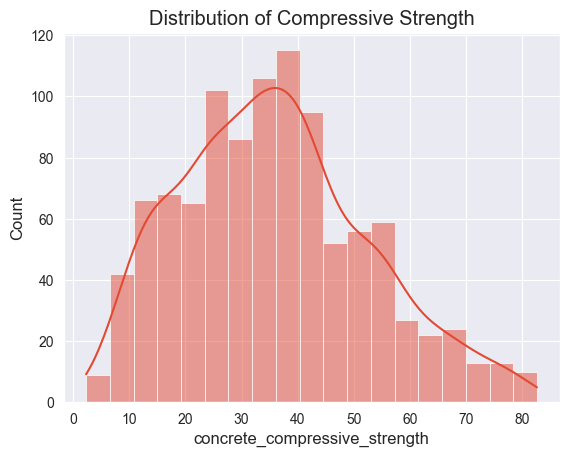

In [9]:
sns.histplot(concrete_df[label_column], kde=True)
plt.title("Distribution of Compressive Strength")
plt.show()

The sns.histplot clearly illustrates that the compressive strength data is not uniformly or normally distributed. Instead, it shows a sporadic and spread-out distribution with many unique or rarely occurring strength values, and potentially some concentrations at the extreme ends of the
measured range.
The data distribution is sparse, has a lack of strong central Tendency, so we need to avoid assumption-heavy models (Simple linear regression) and consider robust models (Decision-tree is expected to perform the best).
That doesn’t mean that we don’t try simple linear regression, but maybe this can already explain why linear regression doesn’t perform well.

#### Correlation between relevant variables:

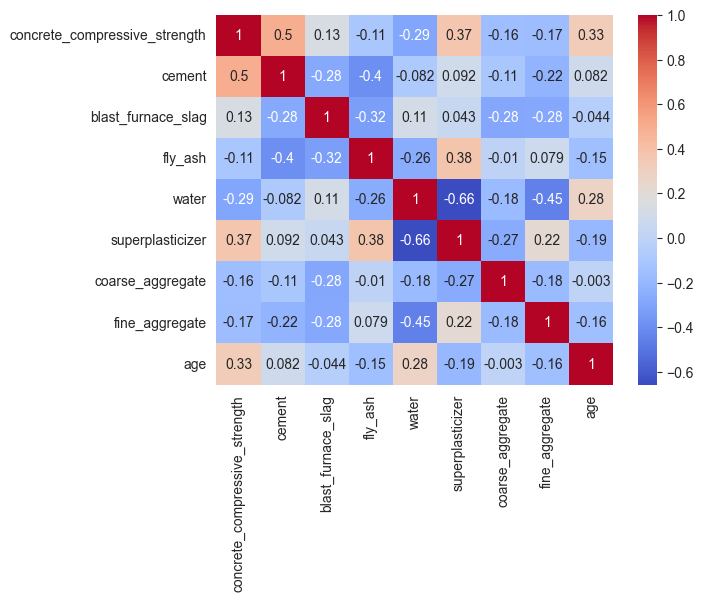

In [10]:
corr = concrete_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

#### Variables that influence concrete strength:

According to the result of the heatmap, it can be seen that **cement** has a moderately strong positive correlation with concrete strength with a value of +0.50, which indicates more cement usually leads to stronger concrete. **Superplasticizer** also has a positive effect with a value of +0.37.
**Age** has a positive effect too , because concrete gets stronger over time.
**Water** has a negative correlation with strength of -0.29, which means more water tends to weaken concrete. This observation is consistent with **Abrams' water-to-cement ratio pronouncement**, which emphasizes that increased water relative to cement typically reduces concrete strength.

#### Multicollinearity:

The highest multicollinearity is the correlation between **water and superplasticizer**, which has a value of -0.66. This indicates they carry overlapping and opposite information. There is also moderate correlation among **cement**, **blast furnace slag**, and **fly ash** because these may act as partial substitutes in the concrete mix, so they tend to move in opposite directions. 

In [11]:
VIFs = [(predictor, variance_inflation_factor(X,_)) \
        for _,predictor in enumerate(list(feature_columns))] 
print('Variance Inflation Factors')
for tup in VIFs:
    print('{:20}'.format(tup[0]), '{:.3f}'.format(tup[1]))

Variance Inflation Factors
cement               15.457
blast_furnace_slag   3.329
fly_ash              4.148
water                82.158
superplasticizer     5.471
coarse_aggregate     84.956
fine_aggregate       72.791
age                  1.699


The variance inflation factors are larger for cement, blast furnace slag, fly ash, water, coarse aggregate, fine aggregate. This also indicates multi-collinearity of the factors mention above.

As mentioned in the lecture content of Machine Learning and Data Analytics(MLDA), VIF equal to 1 shows the absence of collinearity Usually, there is collinearity when VIF is larger than 5.

### Machine Learning Methods:
This project aims to predict concrete compressive strength which is a problem with a quantitative response. According to the lecture content in the fundamental part of MLDA, this task is a **regression task**. In the following part, linear regression, ridge regression, lasso regression, one decision-tree based method are applied. 

### Cross validation:

#### K-fold cross validation:

For supervised machine learning, the goal is to develop a model that can perform accurately not only on the data it was trained on, but also on previously unseen data. To evaluate a model's generalization ability, the **K-fold** method is utilized as the cross validation method.

In [12]:
# define the kfold, shuffle the training and test dataset every time
kf = KFold(n_splits=10, random_state = 0, shuffle = True)

##### Scorers for the model

In [13]:
# Create MSE scorer 
mse_scorer = make_scorer(mean_squared_error)

# Create r2 scorer 
r2 = make_scorer(r2_score)

#### Linear Regression:

##### Statsmodel, outliers and high leverege points:

In [14]:
#Statsmodel fitting, it is used to show the p-values
X_stat = sm.add_constant(concrete_df.iloc[:,0:-1])
y_stat = concrete_df[label_column]

statmodel = sm.OLS(y_stat,X_stat)
estimate = statmodel.fit()

print(estimate.summary())

                                  OLS Regression Results                                 
Dep. Variable:     concrete_compressive_strength   R-squared:                       1.000
Model:                                       OLS   Adj. R-squared:                  1.000
Method:                            Least Squares   F-statistic:                 1.096e+30
Date:                           Thu, 05 Jun 2025   Prob (F-statistic):               0.00
Time:                                   18:58:08   Log-Likelihood:                 28764.
No. Observations:                           1030   AIC:                        -5.751e+04
Df Residuals:                               1021   BIC:                        -5.746e+04
Df Model:                                      8                                         
Covariance Type:                       nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--

According to the result of the fitted model, there is a relationship between the response of concrete compressive strength and **cement, blast furnace slag, fly ash, water, superplasticizer and age**, because they have low p-values, which is smaller than 0.05.

In [15]:
# Obtain the residuals, studentized residuals and the leverages
fitted_values = estimate.fittedvalues
residuals = estimate.resid.values
studentized_residuals = OLSInfluence(estimate).resid_studentized_internal
leverages = OLSInfluence(estimate).influence

Outliers are: []
Comments on joint outliers (in both ax2 and ax3): []


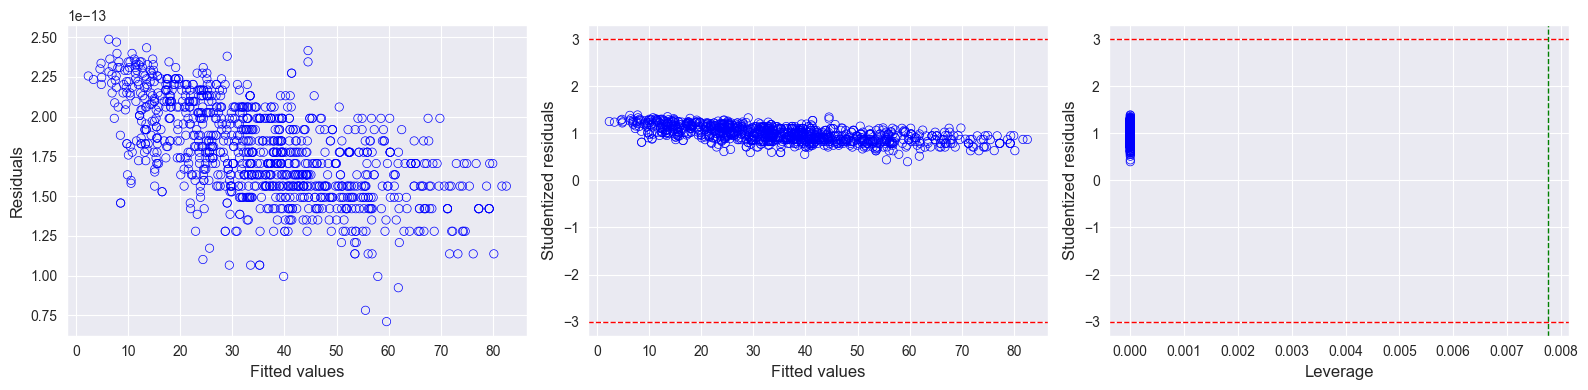

In [16]:
# Calculate thresholds
n = len(fitted_values)
p = X.shape[1] - 1  # exclude constant
leverage_thresh = (p + 1) / n

# Convert to arrays
studentized_residuals = np.asarray(studentized_residuals)
leverages = np.asarray(leverages)

# Identify outlier indices
outlier_indices = np.where(np.abs(studentized_residuals) > 3)[0]
high_leverage_indices = np.where(leverages > leverage_thresh)[0]
outliers = []
for idx in outlier_indices:
    outliers.append(idx)
print("Outliers are:",outliers)

# Find common indices (both outlier and high leverage)
joint_outliers = np.intersect1d(outlier_indices, high_leverage_indices)
high_leverage_and_outliers = [] 

for idx in joint_outliers:
    high_leverage_and_outliers.append(idx)
print("Comments on joint outliers (in both ax2 and ax3):",high_leverage_and_outliers)


# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

# 1. Residuals plot
ax1.scatter(fitted_values, residuals, facecolors='none', edgecolors='b')
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residuals')

# 2. Studentized Residuals plot
ax2.scatter(fitted_values, studentized_residuals, facecolors='none', edgecolors='b')
ax2.axhline(y=3, color='r', linestyle='--', linewidth=1)
ax2.axhline(y=-3, color='r', linestyle='--', linewidth=1)
# Mark joint outliers
for idx in joint_outliers:
    ax2.scatter(fitted_values[idx], studentized_residuals[idx], color='red')
    ax2.annotate(idx, (fitted_values[idx], studentized_residuals[idx]), color='red', fontsize=8)
ax2.set_xlabel('Fitted values')
ax2.set_ylabel('Studentized residuals')

# 3. Leverage vs Studentized Residuals
ax3.scatter(leverages, studentized_residuals, facecolors='none', edgecolors='b')
ax3.axhline(y=3, color='r', linestyle='--', linewidth=1)
ax3.axhline(y=-3, color='r', linestyle='--', linewidth=1)
ax3.axvline(x=leverage_thresh, color='g', linestyle='--', linewidth=1)
# Mark joint outliers
for idx in joint_outliers:
    ax3.scatter(leverages[idx], studentized_residuals[idx], color='red')
    ax3.annotate(idx, (leverages[idx], studentized_residuals[idx]), color='red', fontsize=8)
ax3.set_xlabel('Leverage')
ax3.set_ylabel('Studentized residuals')

plt.tight_layout()
plt.show()

The residuals display a clear pattern, which suggests **non-linearity** in the data. The studentized residuals indicate the presence of two outliers. The leverage plot also reveals several high-leverage points—defined as points with leverage greater than $(p+1)/n=9/1030\approx 0.009$. Notably, both outliers are also high-leverage points. However, since the dataset does not clearly define criteria for excluding data points, all observations, including the outliers, are retained for the subsequent analysis.

##### Scikit-Model:

In [17]:
model = LinearRegression()

mse_scores_lin = cross_val_score(model, X, y, scoring=mse_scorer, cv=kf)

r2_scores = cross_val_score(model, X, y, scoring='r2', cv=kf)

print("\nAverage MSE across folds:", np.mean(mse_scores_lin))    

print("\nAverage R2 across folds:", np.mean(r2_scores))


Average MSE across folds: 109.24732740404936

Average R2 across folds: 0.6057530311729299


#### Polynomial Regression:

Since there is non-linearity in the data, we use the polynomial regression to train the dataset.

cement:
  Lowest MSE = 210.47 at degree 1
blast_furnace_slag:
  Lowest MSE = 263.37 at degree 5
fly_ash:
  Lowest MSE = 273.15 at degree 4
water:
  Lowest MSE = 226.06 at degree 5
superplasticizer:
  Lowest MSE = 241.97 at degree 1
coarse_aggregate:
  Lowest MSE = 267.61 at degree 5
fine_aggregate:
  Lowest MSE = 271.47 at degree 3
age:
  Lowest MSE = 183.45 at degree 4
{'cement': 1, 'blast_furnace_slag': 5, 'fly_ash': 4, 'water': 5, 'superplasticizer': 1, 'coarse_aggregate': 5, 'fine_aggregate': 3, 'age': 4}


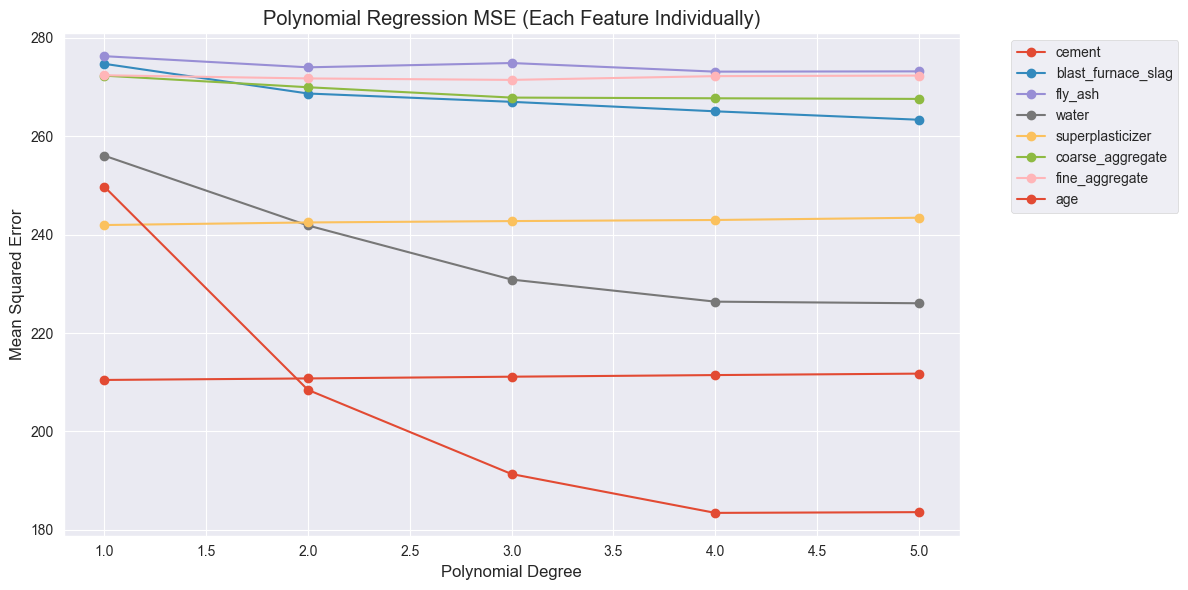

In [18]:
# Store results
results_mse = {}
results_r2 = {}

for feature in feature_columns:
    X_p = concrete_df[[feature]].values
    #Store MSE,R2
    mse_poly = []
    r2_poly = []
    for degree in range(1, 6):  # Degrees 1 to 5
                # Create polynomial features
                poly = PolynomialFeatures(degree=degree)
                X_poly = poly.fit_transform(X_p)
        
                # Create linear regression model
                model = LinearRegression()
        
                # Perform shuffled 10-fold CV and get negative MSE (sklearn returns negative MSE by default)
                mse_scores = cross_val_score(model, X_poly, y, scoring=mse_scorer, cv=kf)
        
                # Store average MSE
                mse_poly.append(np.mean(mse_scores))

                # Store average R2
                r2_poly.append(np.mean(r2_scores))    
        # Store MSEs for this feature
    results_mse[feature] = mse_poly
    results_r2[feature] = r2_poly
    # Plot results

plt.figure(figsize=(12, 6))
best_comb = {}
best_comb = {}

# Plot MSE
for feature, mse_list in results_mse.items():
    plt.plot(range(1, 6), mse_list, marker='o', label=feature)
    
    # Sort MSEs with their degree indices
    sorted_mse = sorted((mse, i+1) for i, mse in enumerate(mse_list))  # (MSE, degree)
    
    min_mse, best_degree = sorted_mse[0]
    best_comb[feature] = best_degree
    
    print(f"{feature}:")
    print(f"  Lowest MSE = {min_mse:.2f} at degree {best_degree}")
print(best_comb)
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Polynomial Regression MSE (Each Feature Individually)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


##### Polynomial Degree Selection Summary and Justification:

In order to model the relationship between the features and the concrete compressive strength, polynomial regression up to degree 5 is applied for each feature. The mean squared error (MSE) was computed using 10-fold cross-validation to assess the predictive performance at each polynomial degree.

While some features achieved their lowest MSE at higher degrees, the improvements over lower degrees were often marginal. Since high-degree polynomial models tend to overfit—capturing noise instead of the underlying patter. Both the lowest and second-lowest MSEs are considered for each feature to guide model complexity choices.

Below is a summary of the best MSEs and their associated degrees:

| Feature            | Lowest MSE | Degree | 
| ------------------ | ---------- | ------ | 
| Cement             | 232.98     | 1      | 
| Blast Furnace Slag | 303.89     | 5      | 
| Fly Ash            | 317.01     | 4      | 
| Water              | 248.95     | 4      | 
| Superplasticizer   | 272.21     | 1      |
| Coarse Aggregate   | 296.42     | 2      | 
| Fine Aggregate     | 293.30     | 1      | 
| Age                | 206.15     | 4      | 


#### Ridge regression:

In [19]:
# define the model
model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2),
    GridSearchCV(
        estimator = Ridge(),
        cv = kf,
        scoring = 'neg_mean_squared_error',
        
        # param_grid determines the parameters to test (alpha is lambda in the Ridge estimator)
        # np.logspace(-3, 2, 50): array from 10^-3 to 10^2 in 50 steps (base default is 10, can also be something else)
        param_grid = {'alpha': np.logspace(-3, 2, 50)},
    )
)
model.fit(X, y)

# obtain the results
lambdas = [p['alpha'] for p in model[2].cv_results_['params']]
mses = [neg_mse * -1 for neg_mse in model[2].cv_results_['mean_test_score']]
best_model = model.named_steps['gridsearchcv'].best_estimator_
best_mse = min(mses)
best_lambda = lambdas[np.argmin(mses)]

print(f"Best alpha:{best_lambda:.2f}:with MSE: {best_mse:.2f}")
model

Best alpha:0.45:with MSE: 59.34


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('gridsearchcv',
                 GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
                              estimator=Ridge(),
                              param_grid={'alpha': array([1.0000e-03, 1.2649e-03, 1.5999e-03, 2.0236e-03, 2.5595e-03,
       3.2375e-03, 4.0949e-03, 5.1795e-03, 6.5513e-03, 8.2864e-03,
       1.0481e-02, 1.3257e-0...
       1.0985e-01, 1.3895e-01, 1.7575e-01, 2.2230e-01, 2.8118e-01,
       3.5565e-01, 4.4984e-01, 5.6899e-01, 7.1969e-01, 9.1030e-01,
       1.1514e+00, 1.4563e+00, 1.8421e+00, 2.3300e+00, 2.9471e+00,
       3.7276e+00, 4.7149e+00, 5.9636e+00, 7.5431e+00, 9.5410e+00,
       1.2068e+01, 1.5264e+01, 1.9307e+01, 2.4421e+01, 3.0888e+01,
       3.9069e+01, 4.9417e+01, 6.2506e+01, 7.9060e+01, 1.0000e+02])},
                              scoring='neg_mean_squared_error'))])

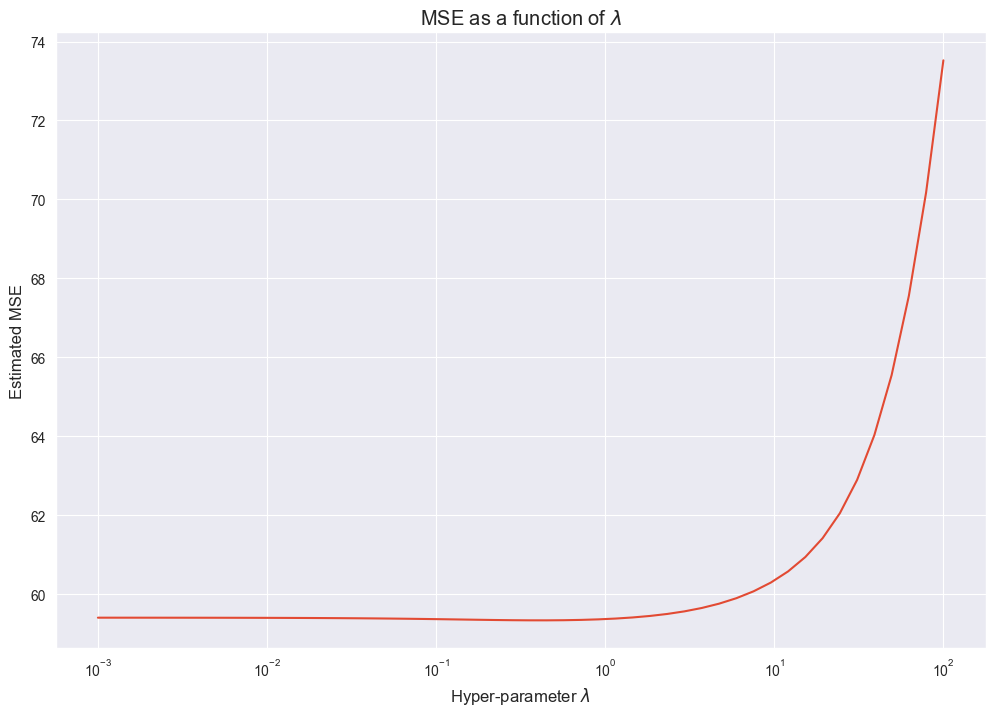

In [20]:
# plot the reults
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(lambdas, mses)
ax.set_xscale('log')
ax.set_title(r"MSE as a function of $\lambda$")
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel("Estimated MSE");
plt.show()

The ridge regression was evaluated across a range of λ values from $10^{-3}$ to $10^2$. The validation MSE decreased with small increases in λ due to reduced overfitting, reaching a minimum at λ = 9.54. Beyond this point, further increases in λ caused the model to underfit the data, resulting in higher MSEs.
Thus, the optimal λ value was selected as 9.54, where the model achieved the lowest MSE of 89.9. 

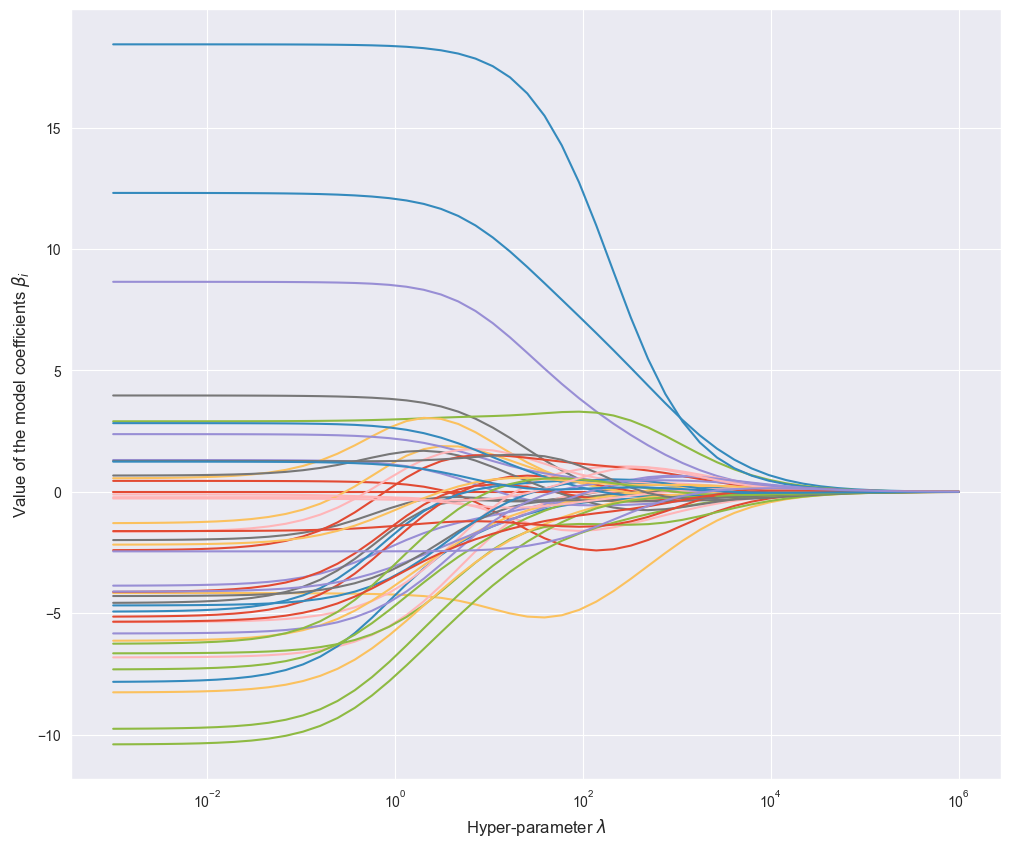

In [21]:
lambdas = np.logspace(-3, 6, 50)
coefficients = list()

# for each lambda define and fit the model and save the obtained parameters in the coefficients list
for lam in lambdas:
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree = 2),
        Ridge(alpha = lam)
    )
    model.fit(X, y)
    coefficients.append(model[2].coef_)

    
# plot the results    
coefficients = np.array(coefficients).T
fig, ax = plt.subplots(figsize = (12, 10))

for coef_vals in coefficients:
    ax.plot(lambdas, coef_vals)
    
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel(r"Value of the model coefficients $\beta_i$")
ax.set_xscale('log');
plt.show()